Disclaimer: 
This colab is based on the notebook published on Kaggle. The original version can be found [here](https://www.kaggle.com/usharengaraju/wids2022-lgbm-starter-w-b#Feature-Scaling) 

# Setting up Kaggle Credentials and download data

In [ ]:
#@title upload your Kaggle credentials
#@markdown You can generate them in your Kaggle user profile

# from google.colab import files
# files.upload()

In [ ]:
#@title Download the WiDS datasets
#@markdown Make sure your credentials are up-to-date and you have accepted the competition's terms and conditions
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

# ! cd content
# ! kaggle competitions download -c widsdatathon2022
# ! unzip train.csv.zip
# ! unzip test.csv.zip

<b>Problem Statement:</b> <p> Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacted by energy policy and infrastructure. Addressing climate change involves mitigation (i.e. mitigating greenhouse gas emissions) and adaptation (i.e. preparing for unavoidable consequences). Mitigation of GHG emissions requires changes to electricity systems, transportation, buildings, industry, and land use. </p>

<p>According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. For example, retrofitted buildings can reduce heating and cooling energy requirements by 50-90 percent. Many of these energy efficiency measures also result in overall cost savings and yield other benefits, such as cleaner air for occupants. This potential can be achieved while maintaining the services that buildings provide.</p>

<b>Goal: </b> <p>
The goal of this competition is to predict the energy consumption using building characteristics and climate and weather variables. </p>

# Importing libraries

In [7]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.5)
plt.rcParams["figure.figsize"] = (10, 5)

## Loading Files and Explorative Data Analysis

We'll start by loading our data (both train and test, but remember not to look at the test set!) and performing some simple analyses to understand the data better.

We'll want to look at:
* which features are included, and their type
* how are features distributed, and do they correlate with our target?
* do we have any missing values? If so, how do we want to handle those?
* ...


In [8]:
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [9]:
# quickly checking size of our train and test set.
# The training set has one additional column, which is our label.
print("Number of train samples are", data.shape)
print("Number of test samples are", test_data.shape)

Number of train samples are (75757, 64)
Number of test samples are (9705, 63)


In [10]:
data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [11]:
# Which columns are in the dataset?
data.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [12]:
# Generate a quick description of your dataset, including key statistics
# (count, mean, std, min, max etc.) for categorical and numerical columns.
data.describe(include="all").T.style

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Year_Factor,75757.000000,nan,nan,nan,4.367755,1.471441,1.000000,3.000000,5.000000,6.000000,6.000000
State_Factor,75757,7,State_6,50840,nan,nan,nan,nan,nan,nan,nan
building_class,75757,2,Residential,43558,nan,nan,nan,nan,nan,nan,nan
facility_type,75757,60,Multifamily_Uncategorized,39455,nan,nan,nan,nan,nan,nan,nan
floor_area,75757.000000,nan,nan,nan,165983.865858,246875.790940,943.000000,62379.000000,91367.000000,166000.000000,6385382.000000
year_built,73920.000000,nan,nan,nan,1952.306764,37.053619,0.000000,1927.000000,1951.000000,1977.000000,2015.000000
energy_star_rating,49048.000000,nan,nan,nan,61.048605,28.663683,0.000000,40.000000,67.000000,85.000000,100.000000
ELEVATION,75757.000000,nan,nan,nan,39.506323,60.656596,-6.400000,11.900000,25.000000,42.700000,1924.500000
january_min_temp,75757.000000,nan,nan,nan,11.432343,9.381027,-19.000000,6.000000,11.000000,13.000000,49.000000
january_avg_temp,75757.000000,nan,nan,nan,34.310468,6.996108,10.806452,29.827586,34.451613,37.322581,64.758065


In [13]:
# Check for missing data
cols_with_missing = [col for col in data.columns if data[col].isnull().any()]
miss_count = data.isna().sum()
miss_df = pd.concat(
    [
        miss_count.rename("Missing count"),
        miss_count.div(len(data)).rename("Missing value"),
    ],
    axis=1,
).loc[miss_count.ne(0)]
miss_df.style.background_gradient(cmap="coolwarm")

,Missing count,Missing value
year_built,1837,0.024249
energy_star_rating,26709,0.352561
direction_max_wind_speed,41082,0.542287
direction_peak_wind_speed,41811,0.551909
max_wind_speed,41082,0.542287
days_with_fog,45796,0.604512


### Cleaning up data types
We want to ensure that categorical columns are represented accordingly. 

In [14]:
categorical_cols = [
    c
    for c in data.columns
    if (1 < data[c].nunique()) & (data[c].dtype != np.number) & (data[c].dtype != int)
]
categorical_cols

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  after removing the cwd from sys.path.


['State_Factor', 'building_class', 'facility_type']

In [15]:
for col in categorical_cols:
    data[col] = data[col].astype("category")

In [16]:
num_col = data.select_dtypes("number").columns
num_col

Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_3

## EDA
We'll now have a closer look at our data.
We'll want to know how our target is distributed, and how our features relate to the target.

Our target is called `site_eui`

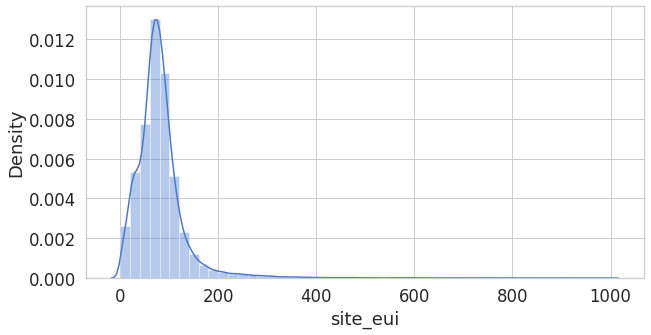

In [17]:
# first, create a plot of the target distribution
sns.distplot(data["site_eui"])

This graph is positively skewed and has a long right side tail. 


Next, let's have a look at the relationship between our target and the categorical variables.

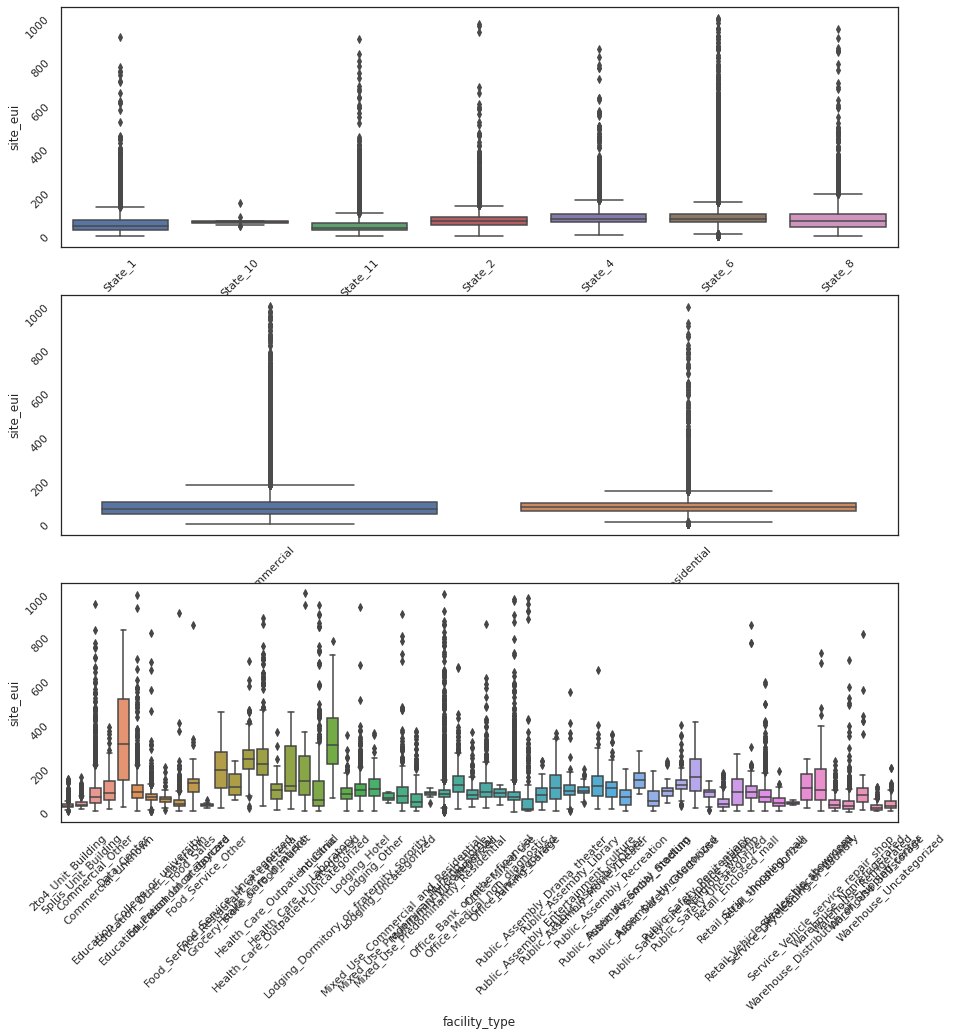

In [18]:
plt.figure(figsize=(15, 15))
sns.set(style="white")
i = 1
for col in categorical_cols:
    plt.subplot(3, 1, i)
    ax = sns.boxplot(data=data, x=col, y="site_eui")
    i = i + 1
    ax.tick_params(labelrotation=45)
plt.show()

There doesn't seem to be a big difference between commercial and residential properties. Some facility types seem to have fairly different target-distributions.

Let's create a similar plot for (a selection of) our numerical features.

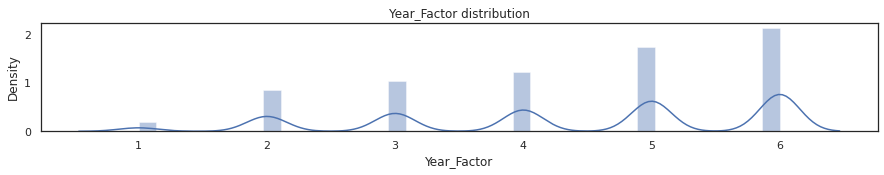

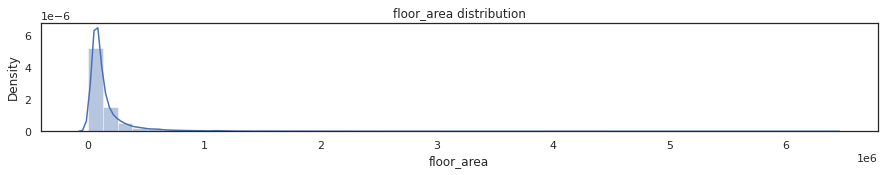

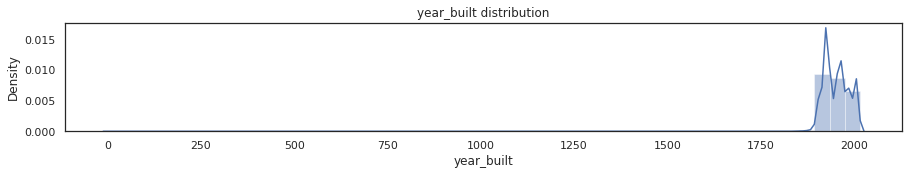

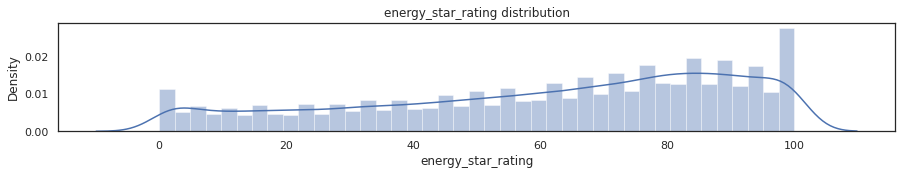

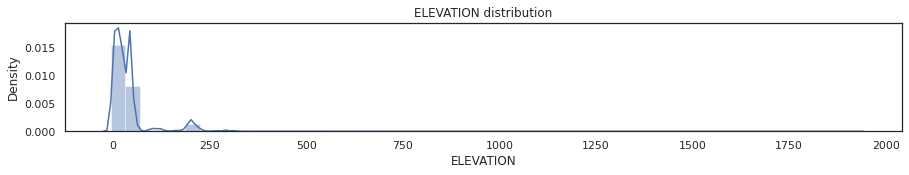

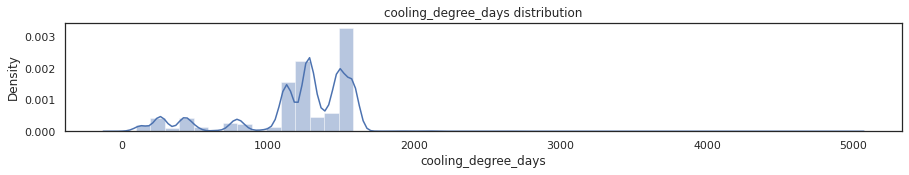

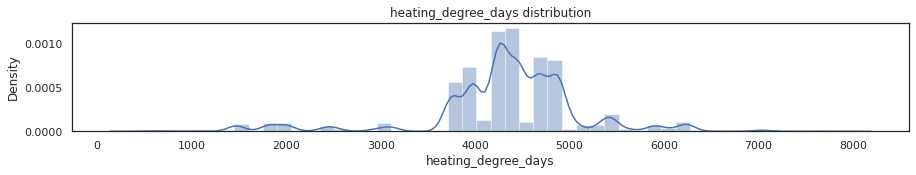

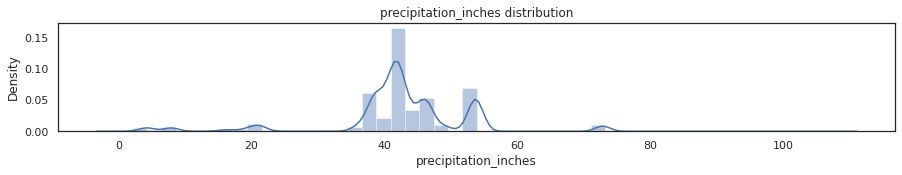

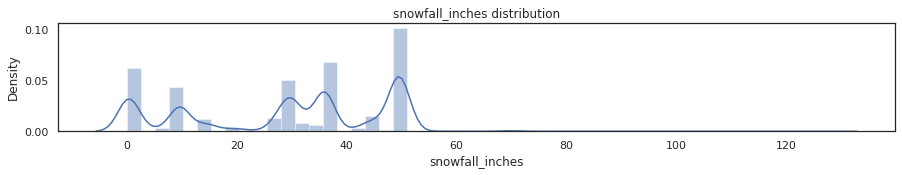

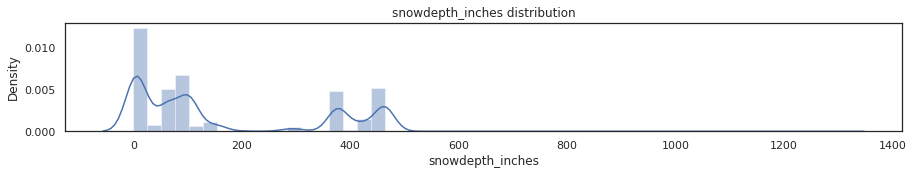

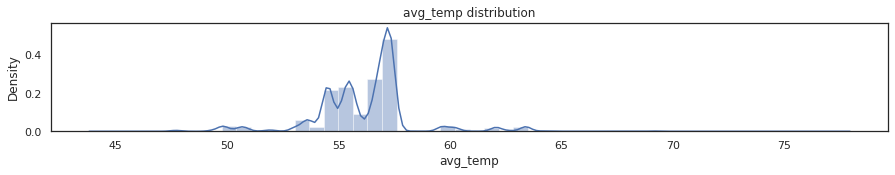

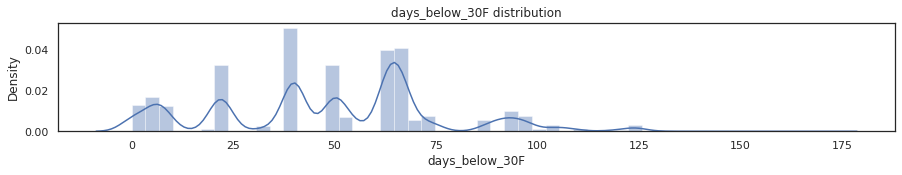

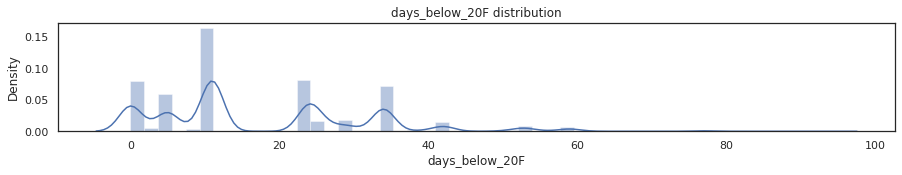

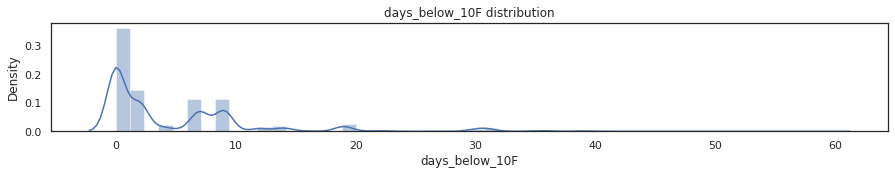

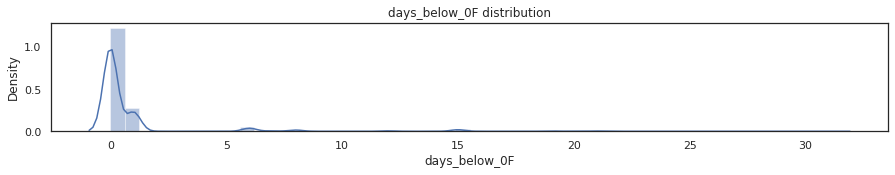

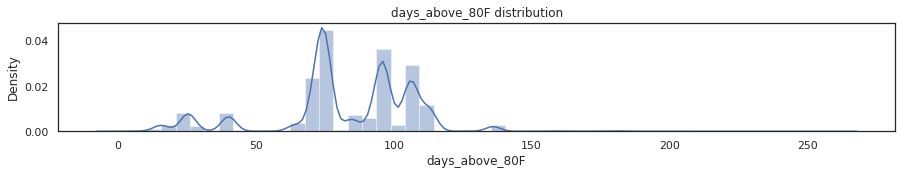

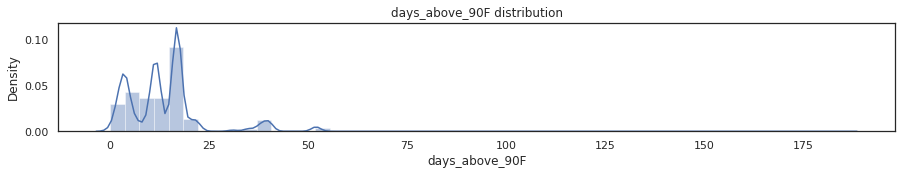

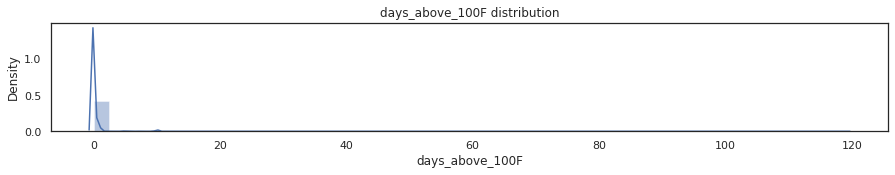

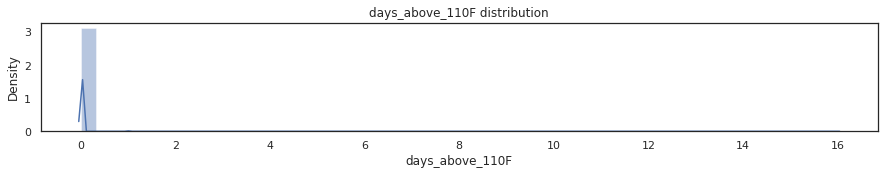

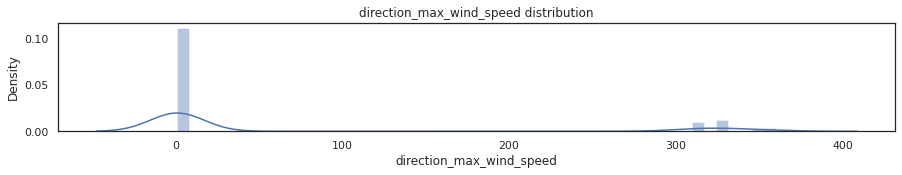

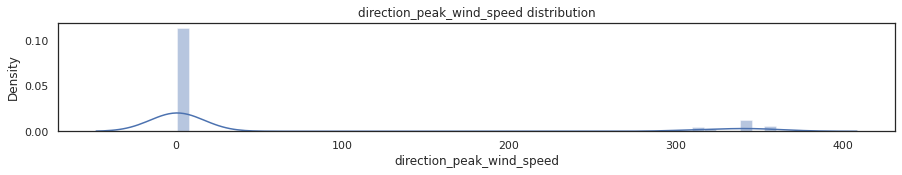

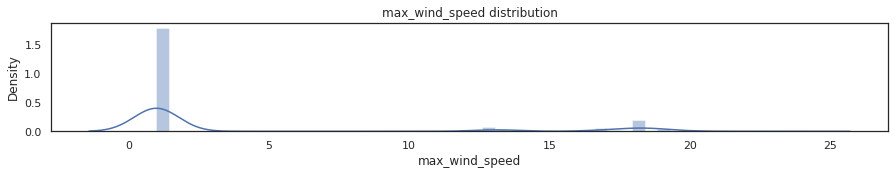

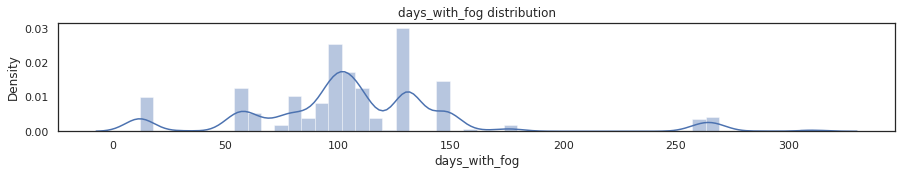

In [19]:
cols = [
    "Year_Factor",
    "floor_area",
    "year_built",
    "energy_star_rating",
    "ELEVATION",
    "cooling_degree_days",
    "heating_degree_days",
    "precipitation_inches",
    "snowfall_inches",
    "snowdepth_inches",
    "avg_temp",
    "days_below_30F",
    "days_below_20F",
    "days_below_10F",
    "days_below_0F",
    "days_above_80F",
    "days_above_90F",
    "days_above_100F",
    "days_above_110F",
    "direction_max_wind_speed",
    "direction_peak_wind_speed",
    "max_wind_speed",
    "days_with_fog",
]

for col in cols:
    plt.figure(figsize=(15, 2))
    sns.distplot(data[col], kde=True)
    plt.title(col + " distribution")
    plt.show()

An important driver of energy consumption is probably the temperature in each month.
Let's visualise the minimum, maximum and average temperatures for each month.

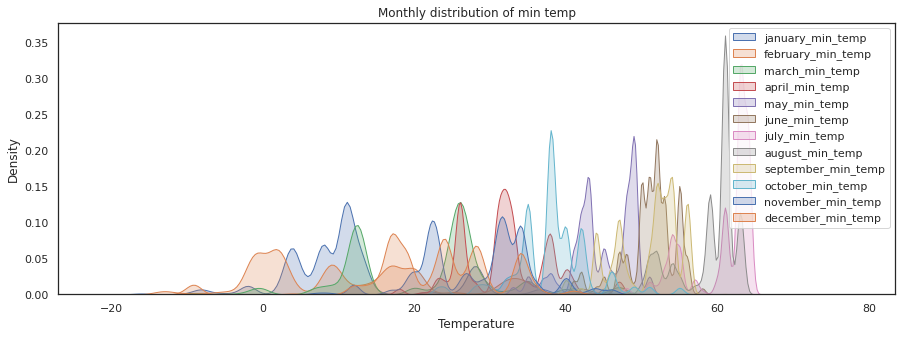

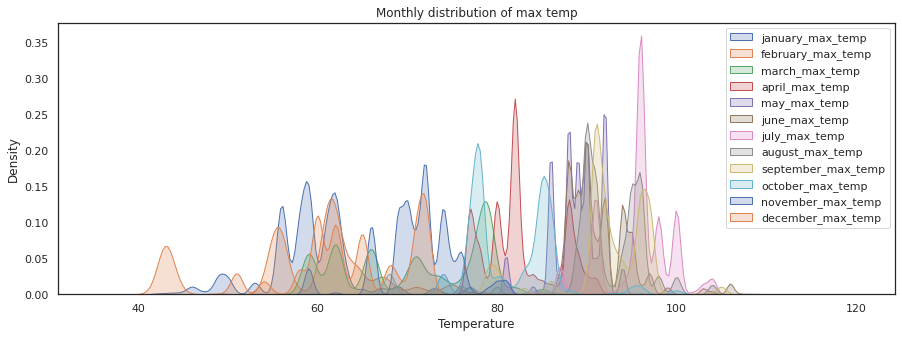

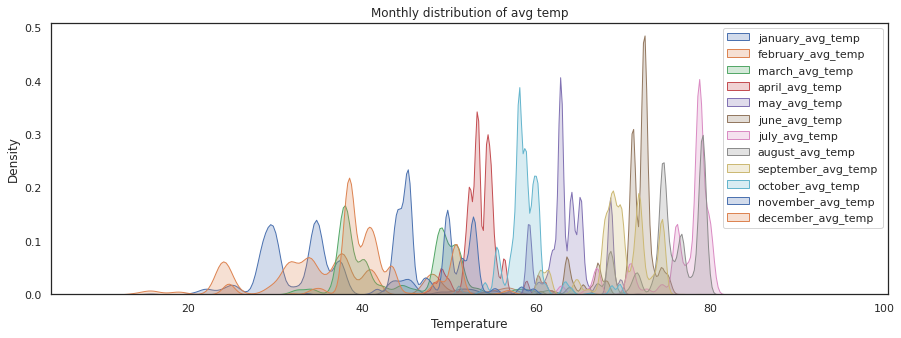

In [20]:
plt.figure(figsize=(15, 5))

min_temp = [
    "january_min_temp",
    "february_min_temp",
    "march_min_temp",
    "april_min_temp",
    "may_min_temp",
    "june_min_temp",
    "july_min_temp",
    "august_min_temp",
    "september_min_temp",
    "october_min_temp",
    "november_min_temp",
    "december_min_temp",
]
for col in min_temp:
    sns.kdeplot(data[col], shade=True)
    plt.xlabel("Temperature")
    plt.title("Monthly distribution of min temp")
plt.legend(min_temp)

plt.figure(figsize=(15, 5))
max_temp = [
    "january_max_temp",
    "february_max_temp",
    "march_max_temp",
    "april_max_temp",
    "may_max_temp",
    "june_max_temp",
    "july_max_temp",
    "august_max_temp",
    "september_max_temp",
    "october_max_temp",
    "november_max_temp",
    "december_max_temp",
]
for col in max_temp:
    sns.kdeplot(data[col], shade=True)
    plt.xlabel("Temperature")
    plt.title("Monthly distribution of max temp")
plt.legend(max_temp)

plt.figure(figsize=(15, 5))
avg_temp = [
    "january_avg_temp",
    "february_avg_temp",
    "march_avg_temp",
    "april_avg_temp",
    "may_avg_temp",
    "june_avg_temp",
    "july_avg_temp",
    "august_avg_temp",
    "september_avg_temp",
    "october_avg_temp",
    "november_avg_temp",
    "december_avg_temp",
]
for col in avg_temp:
    sns.kdeplot(data[col], shade=True)
    plt.xlabel("Temperature")
    plt.title("Monthly distribution of avg temp")
plt.legend(avg_temp)

Next, investigate the correlations between your data. 
It's good to start with a heatmap, and then identify columns that are particularly highly correlated.

['january_avg_temp',
 'february_min_temp',
 'february_avg_temp',
 'february_max_temp',
 'march_min_temp',
 'march_avg_temp',
 'april_min_temp',
 'july_avg_temp',
 'august_min_temp',
 'august_avg_temp',
 'september_min_temp',
 'september_avg_temp',
 'december_avg_temp',
 'cooling_degree_days',
 'heating_degree_days',
 'snowdepth_inches',
 'avg_temp',
 'days_below_30F',
 'days_below_20F',
 'days_below_10F',
 'days_above_80F',
 'direction_peak_wind_speed',
 'max_wind_speed']

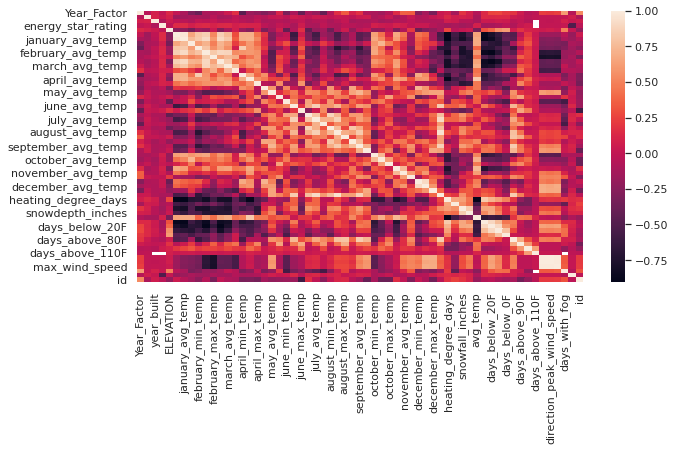

In [21]:
data_cor = data.corr()

sns.heatmap(data_cor)
data_df_upper = data_cor.where(
    np.triu(np.ones(data_cor.shape, dtype=int), k=1).astype(bool)
)
cor80 = [col for col in data_df_upper.columns if any(abs(data_df_upper[col]) >= 0.8)]

cor80

## Data preparation

### Handling missing values

As we've seen above, some of our columns have missing values. We have different options to replace those, and all of them have their pros and cons.

* dropping rows with missing features
* replace with the mean/median in the column
* replace with a fixed value
* replace with a value out of distribution; this would allow us to still fit a model, but effectively keep `nan` as a possible feature-value.

Note that whatever your strategy, you'll need to apply this to your test-data as well.

Tip: have a look at `sklearn.impute.SimpleImputer`!

In [22]:
# year_built: replace with current year.
data["year_built"] = data["year_built"].replace(np.nan, 2022)

## for test data
test_data["year_built"] = test_data["year_built"].replace(np.nan, 2022)

In [23]:
from sklearn.impute import SimpleImputer

null_col = [
    "energy_star_rating",
    "direction_max_wind_speed",
    "direction_peak_wind_speed",
    "max_wind_speed",
    "days_with_fog",
]

imputer = SimpleImputer()
imputer.fit(data[null_col])
data_transformed = imputer.transform(data[null_col])
data[null_col] = pd.DataFrame(data_transformed)

## for test data
test_data_transformed = imputer.transform(test_data[null_col])
test_data[null_col] = pd.DataFrame(test_data_transformed)

In [24]:
data.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.142051,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,62.779974,1.0,12.000000,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,62.779974,1.0,12.000000,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,62.779974,1.0,12.000000,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.000000,1.0,109.142051,3.899395,4


In [25]:
# rechecking null values
cols_with_missing = [col for col in data.columns if data[col].isnull().any()]
cols_with_missing

[]

### Feature one-hot encoding and scaling
First, we need to make sure that all our data is present in numerical format (instead of as a string). For this, we use something called dummy- or one-hot encoding. 
Have a look at `from sklearn.preprocessingOneHotEncoder` or pd.get_dummies for this.

Depending on the model chose, it can be important that all features are on a similar scale (e.g., -1 to +1). This can help the model learn more efficiently and not get 'distracted' by some features having a much larger scale than others.

There are different ways to scale features – have a look at `sklearn.preprocessing` for different Scalers available. 


In [26]:
y = data["site_eui"]
X = data.drop(["site_eui"], axis=1)

In [27]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown="ignore")
X_onehot = ohe.fit_transform(X[categorical_cols])
X_onehot = pd.DataFrame(X_onehot.toarray(), columns=ohe.get_feature_names_out())
X = pd.concat([X.drop(categorical_cols, axis=1), X_onehot], axis=1)

test_data_onehot = ohe.transform(test_data[categorical_cols])
test_data_onehot = pd.DataFrame(
    test_data_onehot.toarray(), columns=ohe.get_feature_names_out()
)
test_data = pd.concat(
    [test_data.drop(categorical_cols, axis=1), test_data_onehot], axis=1
)

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_data)

## Model training

Note: it is usually best to start with a simple model first – we strongly recommend testing linear models before moving to boosted trees.

A few last steps before we can train our first model: 
- we want to split our training data once more, so we can tune our hyperparameters whilst reducing risk of overfitting
- we need to choose a model: it is usually best to start with a simple model first (e.g., a linear one) before moving to more complicated ones.

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=50
)

### Baseline Model: Linear Regression

We start with a simple linear regression model to get a baseline performance on this prediction task. 

In [30]:
from sklearn.linear_model import LinearRegression

baseline_model = LinearRegression()

baseline_model.fit(X_train, y_train)

y_train_baseline_predict = baseline_model.predict(X_train)
y_test_baseline_predict = baseline_model.predict(X_test)

Let's plot our predictions against our actual target values and calculate our model performance both for the training and the validation set.
Have a look at `sklearn.metrics` to see which common evaluation metrics are available.

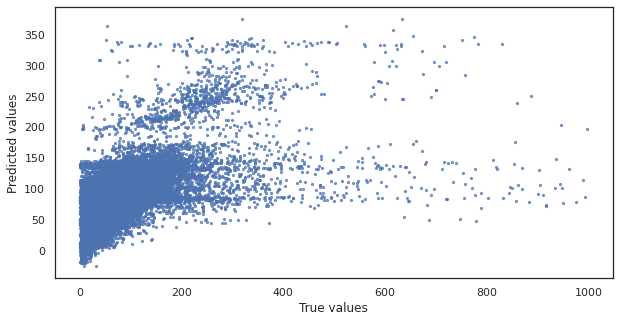

In [31]:
plt.scatter(y_train, y_train_baseline_predict, s=5, alpha=0.7)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

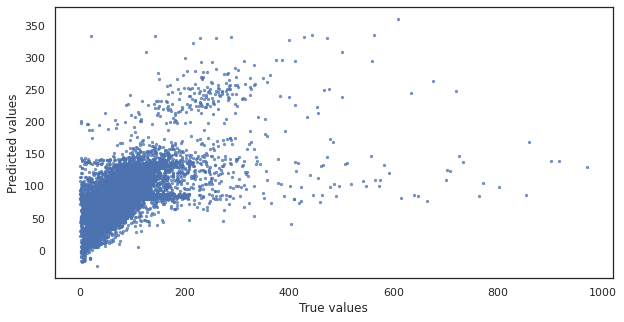

In [32]:
plt.scatter(y_test, y_test_baseline_predict, s=5, alpha=0.7)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, r2_score

train_mse = mean_squared_error(y_train, y_train_baseline_predict)
test_mse = mean_squared_error(y_test, y_test_baseline_predict)
print(
    f"MSE on the training data is {np.round(train_mse, 2)}.",
    f"MSE on the test data is {np.round(test_mse, 2)}.",
)

train_r2 = r2_score(y_train, y_train_baseline_predict)
test_r2 = r2_score(y_test, y_test_baseline_predict)
print(
    f"r2 on the training data is {np.round(train_r2, 2)}.",
    f"r2 on the test data is {np.round(test_r2, 2)}.",
)

MSE on the training data is 2212.66. MSE on the test data is 2030.14.
r2 on the training data is 0.36. r2 on the test data is 0.36.


Overall, this is not too bad for a simple linear model. But let's try something a bit more complicated to see if we can improve the model performance further.

## Non-linear model: Gradient boosted trees example

A powerful and fast algorithm is [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html). The documentation is really helpful, so take some time to have a look there! 

In [34]:
import lightgbm

model = lightgbm.LGBMRegressor()
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

As before, let's plot our model predictions against the true values, and calculate some model performance metrics.

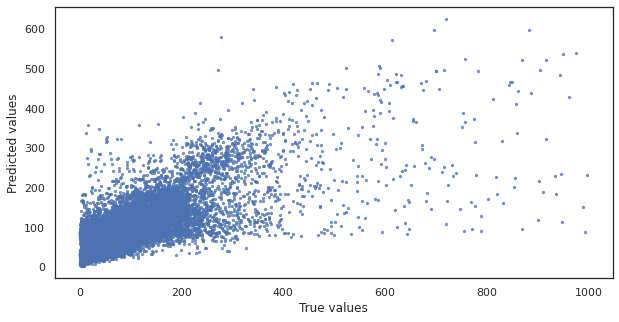

In [35]:
plt.scatter(y_train, y_train_predict, s=5, alpha=0.7)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

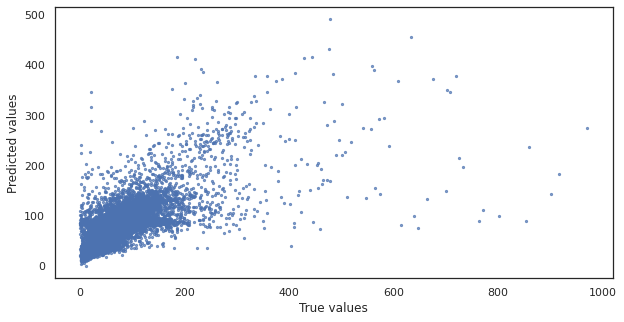

In [36]:
plt.scatter(y_test, y_test_predict, s=5, alpha=0.7)
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [37]:
train_mse = mean_squared_error(y_train, y_train_predict)
test_mse = mean_squared_error(y_test, y_test_predict)
print(
    f"MSE on the training data is {np.round(train_mse, 2)}.",
    f"MSE on the test data is {np.round(test_mse, 2)}.",
)

train_r2 = r2_score(y_train, y_train_predict)
test_r2 = r2_score(y_test, y_test_predict)
print(
    f"r2 on the training data is {np.round(train_r2, 2)}.",
    f"r2 on the test data is {np.round(test_r2, 2)}.",
)

MSE on the training data is 1564.62. MSE on the test data is 1696.99.
r2 on the training data is 0.55. r2 on the test data is 0.47.


Let's see if we can improve this model further!
Next step is using the gridsearch to find the optimal parameters

In [38]:
from sklearn.model_selection import GridSearchCV

model = lightgbm.LGBMRegressor()

# those are just some example parameters to help you get started!

parameters = {
    "objective": ["root_mean_squared_error"],
    "learning_rate": [0.05, 0.005],
    "num_leaves": [10, 20],
    "max_depth": [10, 20],
}

model_grid = GridSearchCV(model, parameters, cv=3, verbose=False)

model_grid.fit(X_train, y_train)

print(model_grid.best_score_)
print(model_grid.best_params_)

0.42201635116168434
{'learning_rate': 0.05, 'max_depth': 20, 'num_leaves': 20, 'objective': 'root_mean_squared_error'}


## Generating predictions on test data (held-out dataset)

Finally, if we are happy with our model, we can use it to generate predictions based on the test-data and upload those as our submission.

Best of luck with the WiDS 2020 Datathon!

In [39]:
# testdata prediction
prediction = model_grid.best_estimator_.predict(test_scaled)
prediction

array([258.33358581, 220.30795605, 213.439968  , ...,  44.36359279,
        44.87933872,  46.71237989])